In [1]:
# Packages used to compile climatology of Princeton! 
# Function for generating histogram
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot

importing Jupyter notebook from histplot.ipynb


In [2]:
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'
# Position: 1 is wind direction, 2 is wind speed, 3 is air temp, 4 is relative humidity,
# 5 is air pressure, 6 is rain/precipitation, 7 is hail accumulation. 

In [60]:
def jan_clim(startday, howdays, position, divideby, pre):
    Jan18 = histplot.getData(18, direct, ASC, startday, howdays, position, float)
    Jan19 = histplot.getData(19, direct, ASC, startday, howdays, position, float)
    Jan20 = histplot.getData(20, direct, ASC, startday, howdays, position, float)
    Jan21 = histplot.getData(21, direct, ASC, startday, howdays, position, float)
    Jantot = np.concatenate([Jan18, Jan19, Jan20, Jan21])
    Jan_total = np.nansum(Jantot)
    print(Jan_total)
    # If it is doing precipitation (choose to divide by number of months)
    if (pre == 1):
        Jan_mean = Jan_total/divideby
    # Divide by number of minutes we have. 
    else: 
        Jan_mean = Jan_total/len(Jantot)
    print(Jan_mean)
    return Jan_mean

In [48]:
# January Climatology 
Jan_pre = jan_clim(1, 31, 6, 4, 1)

176.17000000000004
44.04250000000001


In [62]:
def feb_july_clim(startday, howdays,  position, divideby, feb, pre):
    Mon18 = histplot.getData(18, direct, ASC, startday, howdays, position, float)
    Mon19 = histplot.getData(19, direct, ASC, startday, howdays, position, float)
    if (feb == 2):
        Mon20 = histplot.getData(20, direct, ASC, startday, howdays+1, position, float)
    else:
        Mon20 = histplot.getData(20, direct, ASC, startday+1, howdays, position, float)
    Montot = np.concatenate([Mon18, Mon19, Mon20])
    Mon_total = np.nansum(Montot)
    print(Mon_total)
    if (pre == 1):
        Mon_mean = Mon_total/divideby
    else:
        Mon_mean = Mon_total/len(Montot)
    print(Mon_mean)
    return Mon_mean

In [65]:
# February Climatology 
Feb_pre = feb_july_clim(32, 28, 6, 3, 2, 1)

218.22000000000006
72.74000000000002


In [34]:
# March Climatology
Mar_pre = feb_july_clim(60, 31, 6, 3, 1)
# April Climatology 
Apr_pre = feb_july_clim(91, 30, 6, 3, 1)
#May Climatology 
May_pre = feb_july_clim(121, 31, 6, 3, 1)
# June Climatology 
Jun_pre = feb_july_clim(152, 30, 6, 3, 1)
# July Climatology 
Jul_pre = feb_july_clim(182, 31, 6, 3, 1)

212.47
70.82333333333334
239.13000000000008
79.71000000000002
358.5199999999999
119.50666666666665
298.02
99.33999999999999
370.47
123.49000000000001


In [70]:
def aug_dec_clim(startday, howdays,  position, divideby, pre):
    Mon17 = histplot.getData(17, direct, ASC, startday, howdays, position, float)
    Mon18 = histplot.getData(18, direct, ASC, startday, howdays, position, float)
    Mon19 = histplot.getData(19, direct, ASC, startday, howdays, position, float)
    Mon20 = histplot.getData(20, direct, ASC, startday+1, howdays, position, float)
    Montot = np.concatenate([Mon17, Mon18, Mon19, Mon20])
    Mon_total = np.nansum(Montot)
    print(Mon_total)
    if (pre == 1):
        Mon_mean = Mon_total/divideby
    else:
        Mon_mean = Mon_total/len(Montot)
    print(Mon_mean)
    return Mon_mean

In [74]:
#August Climatology 
Aug_pre = aug_dec_clim(213, 31, 6, 4, 1)
#September Climatology 
Sep_pre = aug_dec_clim(244, 30, 6, 4, 1)
#October Climatology 
Oct_pre = aug_dec_clim(274, 31, 6, 4, 1)
#November Climatology 
Nov_pre = aug_dec_clim(305, 30, 6, 4, 1)
# December Climatology 
Dec_pre = aug_dec_clim(335, 31, 6, 4, 1)

383.33000000000004
95.83250000000001
279.05
69.7625
303.93
75.9825
325.16
81.29
267.44000000000005
66.86000000000001


In [61]:
# Jan Temperature 
Jan_temp = jan_clim(1, 31, 3, 4, 0)

276317.4000000001
1.5474764784946242


In [66]:
# Feb Temperature 
Feb_temp = feb_july_clim(32, 28, 3, 3, 2, 0)

475266.60000000003
3.88289705882353


In [67]:
# March Temp
Mar_temp = feb_july_clim(60, 31, 3, 3, 1, 0)
# April Temp
Apr_temp = feb_july_clim(91, 30, 3, 3, 1, 0)
#May Temp
May_temp = feb_july_clim(121, 31, 3, 3, 1, 0)
# June Temp
Jun_temp = feb_july_clim(152, 30, 3, 3, 1, 0)
# July Temp 
Jul_temp = feb_july_clim(182, 31, 3, 3, 1, 0)

800309.0999999999
5.976023745519712
1422647.7999999998
10.977390083180294
2309461.1000000006
17.246110132027006
2875529.8999999994
22.18995655428399
3451455.2999999993
25.77386288112431


In [72]:
#August Temp  
Aug_temp = aug_dec_clim(213, 31, 3, 4, 0)
#September Temp  
Sep_temp = aug_dec_clim(244, 30, 3, 4, 0)
#October Temp  
Oct_temp = aug_dec_clim(274, 31, 3, 4, 0)
#November Temp 
Nov_temp = aug_dec_clim(305, 30, 3, 4, 0)
# December Temp  
Dec_temp = aug_dec_clim(335, 31, 3, 4, 0)

4275327.5
23.945512030647908
3566582.6999999997
20.641021233744812
2685418.7999999993
15.039728935062023
1360252.8999999997
7.871879466895061
593751.8
3.325222894265233


In [73]:
Average_temperature = np.array([Jan_temp, Feb_temp, Mar_temp, Apr_temp, May_temp, Jun_temp,
                                 Jul_temp, Aug_temp, Sep_temp, Oct_temp, Nov_temp, Dec_temp])
print(Average_temperature)

[ 1.54747648  3.88289706  5.97602375 10.97739008 17.24611013 22.18995655
 25.77386288 23.94551203 20.64102123 15.03972894  7.87187947  3.32522289]


[ 44.0425      72.74        70.82333333  79.71       119.50666667
  99.34       123.49        95.8325      69.7625      75.9825
  81.29        66.86      ]


Text(0.5, 1.0, 'Monthly Average Precipitation')

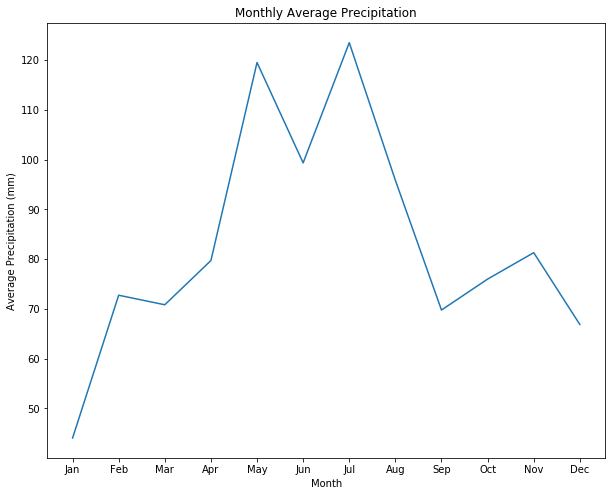

In [76]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Average_precipitation = np.array([Jan_pre, Feb_pre, Mar_pre, Apr_pre, May_pre, Jun_pre,
                                 Jul_pre, Aug_pre, Sep_pre, Oct_pre, Nov_pre, Dec_pre])
print(Average_precipitation)
plt.figure(figsize = (10, 8))
plt.plot(months, Average_precipitation)
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.title('Monthly Average Precipitation')


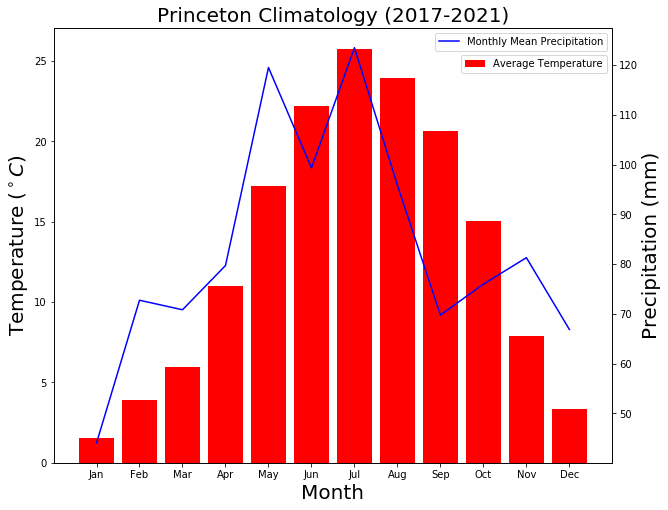

In [93]:
fig, ax1 = plt.subplots(figsize = (10, 8))
ax1.set_xlabel('Month', size = 20)
ax1.set_ylabel('Temperature ($^\circ C$)', size = 20)
ax1.bar(months, Average_temperature, color = 'r')
ax1.legend(['Average Temperature'], bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)', size = 20)
ax2.set_title('Princeton Climatology (2017-2021)', size = 20)
ax2.plot(months, Average_precipitation, color = 'b')

ax2.legend(['Monthly Mean Precipitation'], bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()

